# Horse or human

Horse or human is a smallish binary image recognition dataset. We use it to compare the performance of a fully connected neural network to a convolutional network.

In [1]:
import tensorflow as tf
# if the import doesn't work try "pip install tensorflow-datasets" or "conda install tensorflow-datasets" 
# see https://blog.tensorflow.org/2019/02/introducing-tensorflow-datasets.html
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("seaborn-v0_8")

2024-01-08 16:56:00.745104: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We import the data set. The method <code>load</code> below does not return the data but an abstract object with which we can access the data. As a consequence we do not load all the data into memory at once, but rather have a access to an object that allows for batch-wise loading of the data. This makes things a bit more complicated, but it's also more flexible and scalable. The <code>load</code> method returns, when asked, information on the data, too. 

In [2]:
(train_ds, test_ds), ds_info = tfds.load(
    name="horses_or_humans", 
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

print(ds_info)

tfds.core.DatasetInfo(
    name='horses_or_humans',
    full_name='horses_or_humans/3.0.0',
    description="""
    A large set of images of horses and humans.
    """,
    homepage='http://laurencemoroney.com/horses-or-humans-dataset',
    data_path='/home/henning/tensorflow_datasets/horses_or_humans/3.0.0',
    file_format=tfrecord,
    download_size=153.59 MiB,
    dataset_size=153.53 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=256, num_shards=1>,
        'train': <SplitInfo num_examples=1027, num_shards=2>,
    },
    citation="""@ONLINE {horses_or_humans,
    author = "Laurence Moroney",
    title = "Horses or Humans Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/horses-or-humans-dataset"
    }""",
)


2024-01-08 16:56:03.640266: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-08 16:56:03.641607: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


We learn that the data has format <code>(300,300,3)</code>, which means 300x300 pixels and 3 colour channels (RGB). We can easily have a peek at some samples.

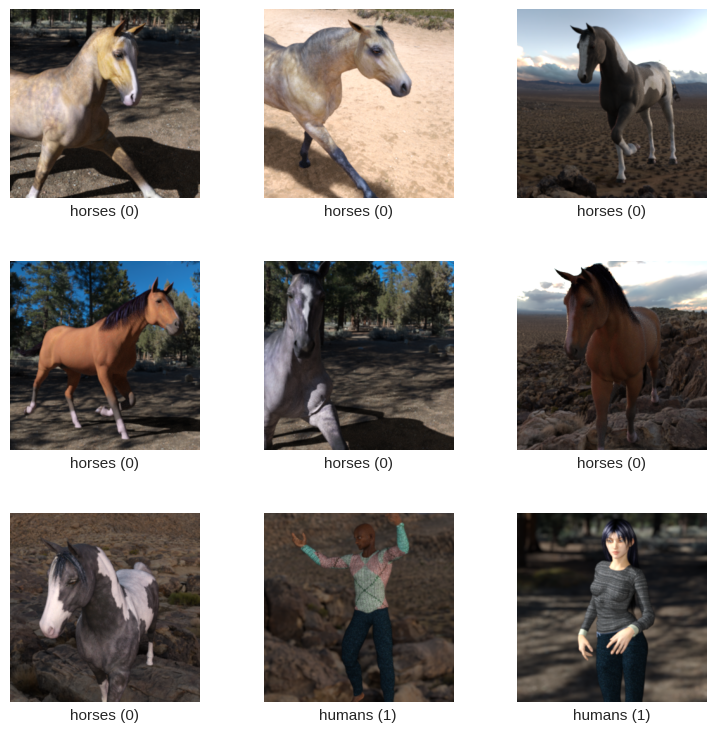

In [3]:
tfds.show_examples(train_ds,ds_info,rows=3,cols=3)
pass

Oh, backgrounds will make this task challenging!

Let's look at the shape of the data. This is surprisingly complicated -- don't ask me why. <code>take(1)</code> generates a data set of with a single sample. However, we still need to iterate over it. To do so, we turn the data set into an iterator, with <code>iter</code>, and then immediately pull out the first element with <code>next</code>.

In [4]:
img,label=next(iter(train_ds.take(1)))
print(img.shape)

(300, 300, 3)


Let's look at how the image is stored. 

In [5]:
img.numpy()[:2,:2,:]

array([[[185, 172, 152],
        [185, 172, 151]],

       [[185, 172, 151],
        [184, 172, 151]]], dtype=uint8)

Aha. Each image is represented by an array of type uint8, which means that in each colour channel the intensities go from 0 to 255. Tensorflow expects floats, and it's best if the data has values in [0,1]. We have to normalise and change the type.

In [6]:
def normalise(image, label):
  return tf.cast(image, tf.float32) / 255., label

# we fix a batch size
batch_size=16

train_ds = train_ds.map(normalise)  # normalise the data
train_ds = train_ds.shuffle(ds_info.splits['train'].num_examples) # shuffle between epochs
train_ds = train_ds.batch(batch_size) # data is loaded in batches of 10

test_ds = test_ds.map(normalise) # we have to do the same with the test set
test_ds = test_ds.batch(batch_size)

# let's also fix a number of epochs for training, 12 seems fine
epochs=12

## Fully connected neural network

We set up three hidden layers, one output unit with logistic activation.

In [7]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(300,300,3)),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dense(20, activation='relu'),
  tf.keras.layers.Dense(20, activation='relu'),
  tf.keras.layers.Dense(1,activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 270000)            0         
                                                                 
 dense (Dense)               (None, 30)                8100030   
                                                                 
 dense_1 (Dense)             (None, 20)                620       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 8,101,091
Trainable params: 8,101,091
Non-trainable params: 0
_________________________________________________________________


Note: as the input images are large, there are a huge number of weights for the first hidden layer.

In [8]:
model.compile(
    run_eagerly=True,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'],
)

history=model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/12
65/65 [==============================] - 8s 104ms/step - loss: 2.0668 - accuracy: 0.6417
Epoch 2/12
65/65 [==============================] - 7s 104ms/step - loss: 0.2705 - accuracy: 0.8851
Epoch 3/12
65/65 [==============================] - 7s 104ms/step - loss: 0.3607 - accuracy: 0.8676
Epoch 4/12
65/65 [==============================] - 7s 100ms/step - loss: 0.3160 - accuracy: 0.8754
Epoch 5/12
65/65 [==============================] - 7s 101ms/step - loss: 0.4041 - accuracy: 0.8598
Epoch 6/12
65/65 [==============================] - 7s 101ms/step - loss: 0.1288 - accuracy: 0.9474
Epoch 7/12
65/65 [==============================] - 7s 102ms/step - loss: 0.0903 - accuracy: 0.9640
Epoch 8/12
65/65 [==============================] - 8s 106ms/step - loss: 0.1047 - accuracy: 0.9640
Epoch 9/12
65/65 [==============================] - 8s 107ms/step - loss: 0.3108 - accuracy: 0.9309
Epoch 10/12
65/65 [==============================] - 8s 106ms/step - loss: 0.6978 - accuracy: 0.8169

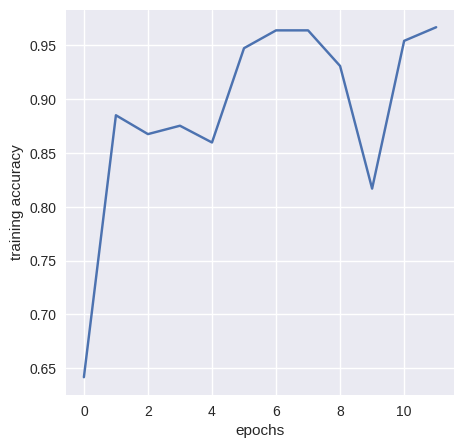

In [9]:
fig,ax=plt.subplots(figsize=(5,5))
ax.set_ylabel("training accuracy")
ax.set_xlabel("epochs")
ax.plot(history.history["accuracy"])

In [10]:
model.evaluate(test_ds)

16/16 [==============================] - 0s 14ms/step - loss: 0.3823 - accuracy: 0.8711


[0.38230443000793457, 0.87109375]

As we can see, the network doesn't fit the training set very well, and has mediocre test error. 

## Convolutional neural network

Next, we set up three convolutional layers, interspersed with [pooling layers](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/). The network is topped up with a fully connected layer. The parameters for the convolutional and pooling layers are not very well fine-tuned.

In [11]:
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(300, 300, 3)))
model2.add(tf.keras.layers.MaxPooling2D((5, 5)))
model2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D((3, 3)))
model2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D((2, 2)))
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(10, activation='relu'))
model2.add(tf.keras.layers.Dense(1,activation='sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 296, 296, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 19, 19, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 64)        

Note that the network has far fewer weights than the fully connected network above.

What do the parameters for the convolutional layers mean? Take the first one:
<code>Conv2D(32, (5, 5), activation='relu', input_shape=(300, 300, 3))</code>

We have encountered the parameters <code>activation</code> and <code>input_shape</code> before, and their names explain quite well what they do. What about <code>Conv2D(32, (5, 5), ...</code>?
* <code>32</code> is the number of filters, ie, kernels, that are learned. This will be the last dimension of the output of this layer.
* <code>(5,5)</code> determines the dimension of the kernels. The kernels, however, will not have dimensions $5\times 5$ but $5\times 5\times 3$. Why that? Because the images have dimensions $300\times 300\times 3$ (the last three are one entry for each colour RGB), the kernels have dimensions $5\times 5\times 3$. We can verify this by observing that the number of parameters that <code>model2.summary</code> outputs for the first layer is $$2432=5\cdot 5\cdot 3\cdot 32+32$$ Why $+32$? That's the bias for each ReLU associated with the $32$ kernels.

In [12]:
model2.compile(
    run_eagerly=True,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'],
)

history2=model2.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/12
65/65 [==============================] - 25s 370ms/step - loss: 0.6633 - accuracy: 0.6280
Epoch 2/12
65/65 [==============================] - 25s 369ms/step - loss: 0.2275 - accuracy: 0.9094
Epoch 3/12
65/65 [==============================] - 25s 371ms/step - loss: 0.0953 - accuracy: 0.9649
Epoch 4/12
65/65 [==============================] - 25s 372ms/step - loss: 0.0650 - accuracy: 0.9786
Epoch 5/12
65/65 [==============================] - 25s 375ms/step - loss: 0.0290 - accuracy: 0.9873
Epoch 6/12
65/65 [==============================] - 28s 416ms/step - loss: 0.0199 - accuracy: 0.9922
Epoch 7/12
65/65 [==============================] - 28s 416ms/step - loss: 0.0133 - accuracy: 0.9961
Epoch 8/12
65/65 [==============================] - 28s 416ms/step - loss: 0.0094 - accuracy: 0.9981
Epoch 9/12
65/65 [==============================] - 26s 390ms/step - loss: 0.0049 - accuracy: 0.9981
Epoch 10/12
65/65 [==============================] - 25s 376ms/step - loss: 0.0018 - accura

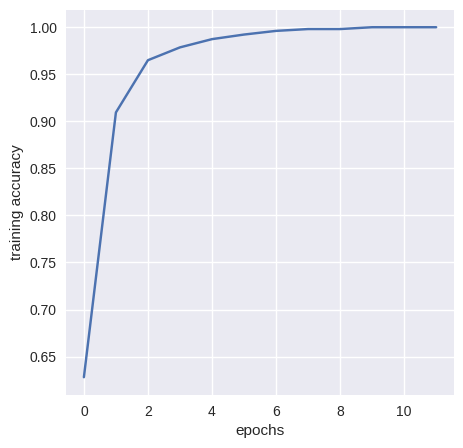

In [13]:
fig,ax=plt.subplots(figsize=(5,5))
ax.set_ylabel("training accuracy")
ax.set_xlabel("epochs")
ax.plot(history2.history["accuracy"])

In [14]:
model2.evaluate(test_ds)

16/16 [==============================] - 2s 113ms/step - loss: 1.5360 - accuracy: 0.8594


[1.5360112190246582, 0.859375]

We see that the convolutional network fits the training set perfectly, and that with far fewer weights than the fully connected network above had. The test error, however, is on the same order as for the fully connected network. Clearly, the network is overfitting. We should use dropout or early stopping or both to improve the performance.